# Final notebook

This notebook brings a showcase for the functions developed so far
and some relevant discussion. 
> Analysis for several years - Done

> Predicting model - Done

> Deployment working

> Create the SQL databasis to save RAM (the *Several years* analysis
is quite ram consuming)

> Investigate the acquisition frequency of the satellites (and decide which one to use)

- [Fire events distribution throughout the entire country:](#fire_events_given_year)
Within this part the user chooses the year where he/she interestered in analyzing
and the app returns a plot containing the fire event distribution for the entire country.
At its side it is shown the biome distribution, then the user might check in which biomes
those fire events are distributed.
- [Fire events distribution for a given biome and year:](#specific_biome_year)
Here the user chooses the biome which he/she is interested in analyzing. The app
then returns three plots: the fire events distribution **for that biome** in the
Brazil map. A pie chart containing the distribution of fire events per biome during
that year and the desired biome is exploded within the piechart. Also the time series
for the fire events distrubtion along the year is shown. As an inset it is shown the
preciptation throughout the year where the user can analyze the dry season prior the
beginning of the burning season (for most biomes, perhaps only Pampa, where it doesn't occur).
- [Several year analysis (To be implemented in the webapp):](#several_year_analysis) 
This part the user chooses the years which he/she is interested in analyzing and
the biome. The app returns the timeseries for each year on top of each other (*i.e.,*
the x-axis starts in January and ends in December) Then user can verify the distribution
of fire events for different years. Despite being very nice to see, it doesn't quantify 
that well how it indeed is. To do so, we also include a pie chart showing the percentage
for each year.



In [87]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_theme(style="darkgrid")

In [4]:
cols = ['bioma','latitude', 'longitude', 'riscofogo', 'precipitacao', 'datahora']

df2014 = pd.read_csv('../../dataset/data2014.csv', parse_dates = True, index_col = 'datahora', usecols = cols)
df2015 = pd.read_csv('../../dataset/data2015.csv', parse_dates = True, index_col = 'datahora', usecols = cols)
df2016 = pd.read_csv('../../dataset/data2016.csv', parse_dates = True, index_col = 'datahora', usecols = cols)
df2017 = pd.read_csv('../../dataset/data2017.csv', parse_dates = True, index_col = 'datahora', usecols = cols)
df2018 = pd.read_csv('../../dataset/data2018.csv', parse_dates = True, index_col = 'datahora', usecols = cols)
df2019 = pd.read_csv('../../dataset/data2019.csv', parse_dates = True, index_col = 'datahora', usecols = cols)

dict_year = {2014 : df2014, 2015 : df2015, 2016 : df2016, 2017 : df2017 , 2018 : df2018 , 2019 : df2019}

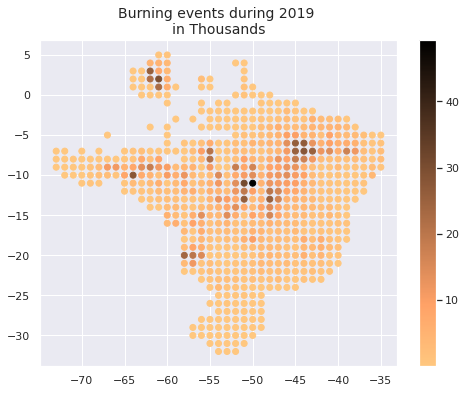

In [39]:
def fire_map_dist(year, ax = ax):
    ## getting the dataframe and risk of fire = 1
    
    df = dict_year[year].drop(columns = ['bioma', 'precipitacao'])
    df = df[df.riscofogo == 1].round(0)
    
    ## Grouping by latitude, longitude and counting the number of fire events
    fire_loc_gb = df.groupby(['latitude', 'longitude'])
    
    number_events = []
    lat = []
    long = []

    for info, dataframe in fire_loc_gb:
        lat.append(info[0])
        long.append(info[1])
        number_events.append(len(dataframe))
    
    ## Creating the dataframe with these information
    df_fire_loc = pd.DataFrame()

    df_fire_loc['latitude'] = lat
    df_fire_loc['longitude'] = long
    df_fire_loc['number_events'] = number_events
    
    scatter = ax.scatter(x = df_fire_loc.longitude, y = df_fire_loc.latitude,
                         c = df_fire_loc.number_events/1000,
                         cmap = 'copper_r')#gnuplot_r
    ax.set_title('Burning events during {} \nin Thousands'.format(year), fontsize = 14)
    
    return ax, scatter

## Plotting the fire distribution
fig, ax = plt.subplots(figsize = (8,6))

fire_map = fire_map_dist(2019, ax)
## Setting the color for the figure

plt.colorbar(fire_map[1], ax = ax)

plt.show()

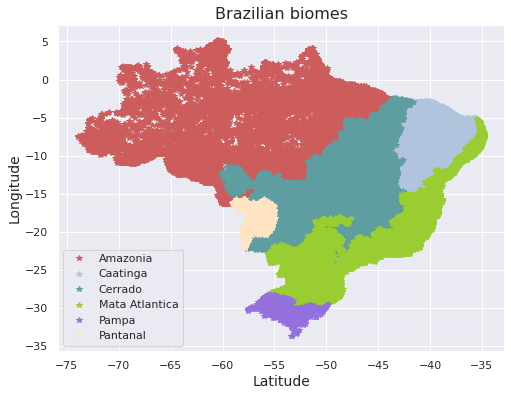

In [51]:
def biomes_distribution(df2014, ax = ax):
    df_biome = df2014[['bioma', 'latitude', 'longitude']].copy().round(1)

    df_biome = df_biome.drop_duplicates(subset = ['latitude', 'longitude'])

    gb_biome = df_biome.groupby('bioma')

    biomes = ['Amazonia', 'Mata Atlantica', 'Cerrado', 'Pampa', 'Caatinga', 'Pantanal']
    colors = ['indianred', 'yellowgreen', 'cadetblue', 'mediumpurple', 'lightsteelblue', 'bisque']

    color_dict = dict(zip(biomes, colors))
    
    
    ## Looping through the biomes
    for biome_name, df in gb_biome:
        ax.plot(df.longitude, df.latitude, marker = '*',
        label = biome_name, linestyle = '', c = color_dict[biome_name])

    ax.set_xlabel('Latitude', fontsize = 14)
    ax.set_ylabel('Longitude', fontsize = 14)
    ax.set_title('Brazilian biomes', fontsize = 16)
    ax.legend(loc = 'lower left')
    
    return ax

fig, ax = plt.subplots(figsize = (8, 6))
biomes_distribution(df2014, ax)
plt.show()

# Single year analysis

## First part

### Number of burning events for an specific year

> The user enters the year and the app returns the number of burning events distribution
throughout the entire country. Since most people are not familiar with the biomes distribution,
a map containing it is shown as an auxiliary plot.

For instance, let's analyse the year of 2019
<a id='fire_events_given_year'></a>

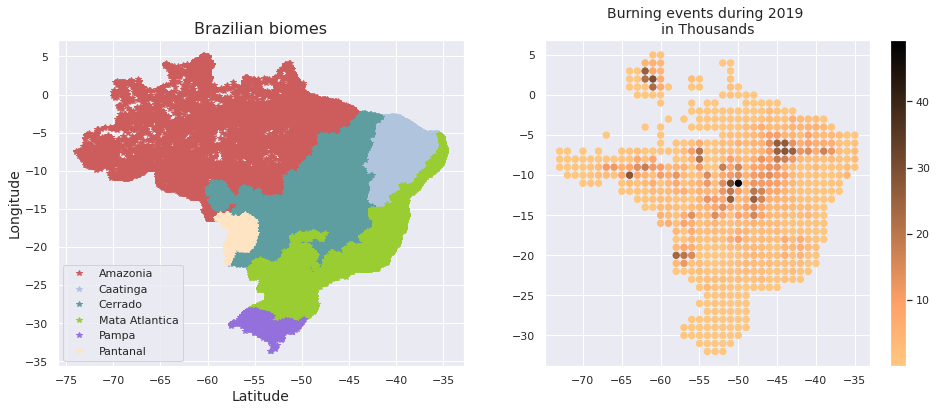

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))

biomes_distribution(df2014, ax = ax1)
fire_map = fire_map_dist(2019, ax = ax2)

fire_map = fire_map_dist(2019, ax2)
## Setting the color for the figure

plt.colorbar(fire_map[1], ax = ax2)

plt.show()

## Second part

### Distribution for an specific biome

> At this second part the user enters with an specific biome on top of what was entered
previously (the year) and gets a more complementary and quantitative for the interesting biome.

Now we consider the Pantanal, for sake of curiosity.

<a id='specific_biome_year'></a>

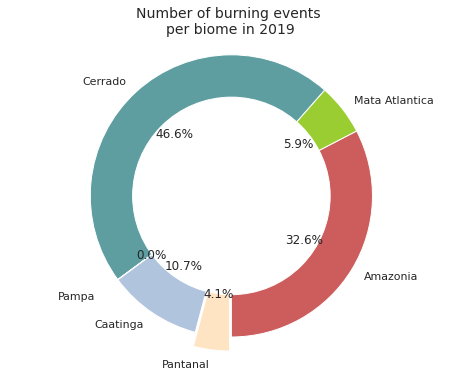

In [57]:
def pie_chart_year(year, biome, ax = ax):
    
    biomes = ['Amazonia', 'Mata Atlantica', 'Cerrado', 'Pampa', 'Caatinga', 'Pantanal']
    fire_biome = []
    
    df = dict_year[year][['bioma', 'riscofogo']].copy()
    df = df[df.riscofogo == 1]
    
    ## COUNTING THE NUMBER OF BURNING EVENTS PER BIOME FOR AN SPECIFIC YEAR
    
    for biome_for in biomes:
        fire_biome.append(len(df[df.bioma == biome_for]))

    ## EXPLODING THE DESIRED BIOME
    
    index = biomes.index(biome)
    explode = [0, 0, 0, 0.1, 0, 0]
    explode[index] = 0.1
    
    ## PLOTTING
    colors = ['indianred', 'yellowgreen', 'cadetblue', 'black', 'lightsteelblue', 'bisque']
    
    ax.pie(fire_biome, labels = biomes, autopct = '%1.1f%%',
           explode = explode, startangle=-90, colors = colors)
    ax.axis('equal')
    ax.set_title('Number of burning events \nper biome in {}'.format(year),
                 fontsize = 14)
    
    #ADDING A WHITE CIRCLE AT THE CENTER (DONUT CHART)
    centre_circle = plt.Circle((0,0),0.70,fc = 'white')
    ax.add_patch(centre_circle)
    
    return ax

fig, ax = plt.subplots(figsize = (8, 6))

pie_chart_year(2019, 'Pantanal', ax)

plt.show()

In [81]:
biomes = ['Amazonia', 'Mata Atlantica', 'Cerrado', 'Pampa', 'Caatinga', 'Pantanal']
colors = ['indianred', 'yellowgreen', 'cadetblue', 'mediumpurple', 'lightsteelblue', 'bisque']
    
color_dict = dict(zip(biomes, colors))


def plot_biome_map(year, biome, ax = ax):
    ## Getting the data
    
    df = dict_year[year].copy()
    df = df[(df.riscofogo == 1) & (df.bioma == biome)].copy()
    
    df = df.round(1)

    gb_loc = df.groupby(['latitude', 'longitude'])

    latitude = []
    longitude = []
    number_events = []

    for info, df in gb_loc:
        latitude.append(info[0])
        longitude.append(info[1])
        number_events.append(df.riscofogo.sum())
    

    ax.set_xlabel('Latitude', fontsize = 14)
    ax.set_ylabel('Longitude', fontsize = 14)

    plot = ax.scatter(x = longitude, y = latitude, c = number_events, cmap = 'magma_r')

    for biome_name, dataframe in gb_biome:
        if biome_name != biome:
            ax.scatter(dataframe.longitude, dataframe.latitude, marker = '*',
                    label = biome_name, c = color_dict[biome_name])

    ax.set_title('Fire distribution in {} \nduring {}'.format(biome, year), fontsize = 16)
    ax.legend(loc = 'lower left')
    
    return ax, plot

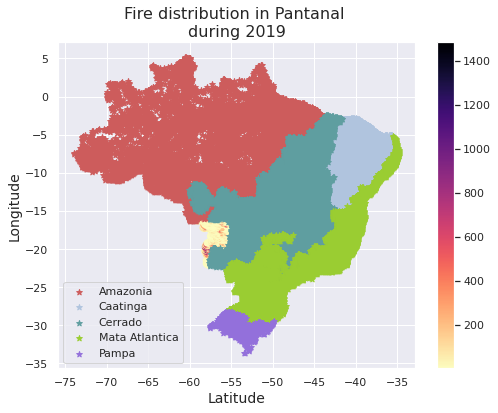

In [82]:
fig, ax = plt.subplots(figsize = (8,6))

plot_biome_fire = plot_biome_map(2019, 'Pantanal', ax)[1]

fig.colorbar(plot_biome_fire, ax = ax)

plt.show()

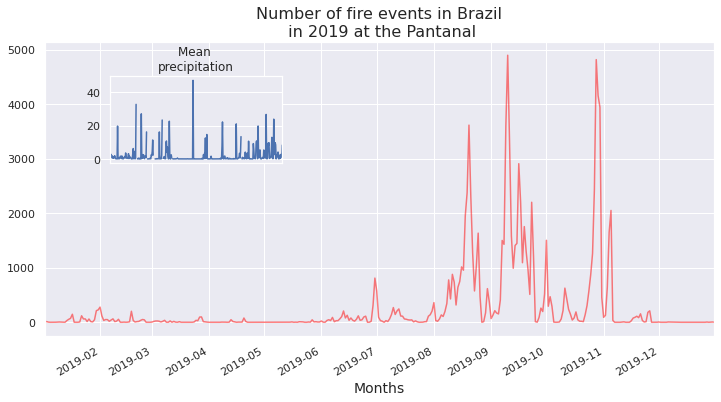

In [167]:
def timeseries_year_biome(year, biome, ax = ax, day1 = 0, day2 = 0, month1 = 0, month2 = 0, position = [0.2, 0.6, .2, .2]):
    
    df = dict_year[year][['riscofogo', 'precipitacao', 'bioma']].copy()
    
    # electing the chosen biome
    df = df[df.bioma == biome]
    df = df.drop(columns = 'bioma')
    
    # fire vector
    df_fire = df[df['riscofogo'] == 1]['riscofogo'].copy()
    df_fire = df_fire.resample('D').sum()
    
    # precipitation vector
    df_prec = df['precipitacao'].resample('D').mean()
   
    ### PLOTTING SECTION ###
    
    ## Fire events plot##
    ax.plot(df_fire, alpha = 0.5, c = 'red')

    ax.set_xlabel('Months', fontsize = 14)
    ax.set_xlim(df_fire.index[0], df_fire.index[-1])
    ax.set_title('Number of fire events in Brazil\n in {} at the {}'.format(year, biome),
                 fontsize = 16)

    plt.gcf().autofmt_xdate()
    

    
    if day1 != 0 and day2 != 0 and month1 != 0 and month2 != 0:
        x1 = datetime.date(year, month1, day1)
        x2 = datetime.date(year, month2, day2)
        ax.axvspan(x1, x2, color='gray', alpha=0.2, lw=0)

    ## Mean precipitation plot ##
    ax_inset = plt.axes(position)
    ax_inset.plot(df_prec)
    ax_inset.set_xlim(df_prec.index[0], df_prec.index[-1])

    ax_inset.set_title('Mean \nprecipitation')
    ax_inset.set_xticks([])
    
    if day1 != 0 and day2 != 0 and month1 != 0 and month2 != 0:
        ax.axvspan(x1, x2, color='gray', alpha=0.2, lw=0)

    return ax


fig, ax = plt.subplots(figsize = (12, 6))

timeseries_year_biome(2019, 'Pantanal', ax)

plt.show()

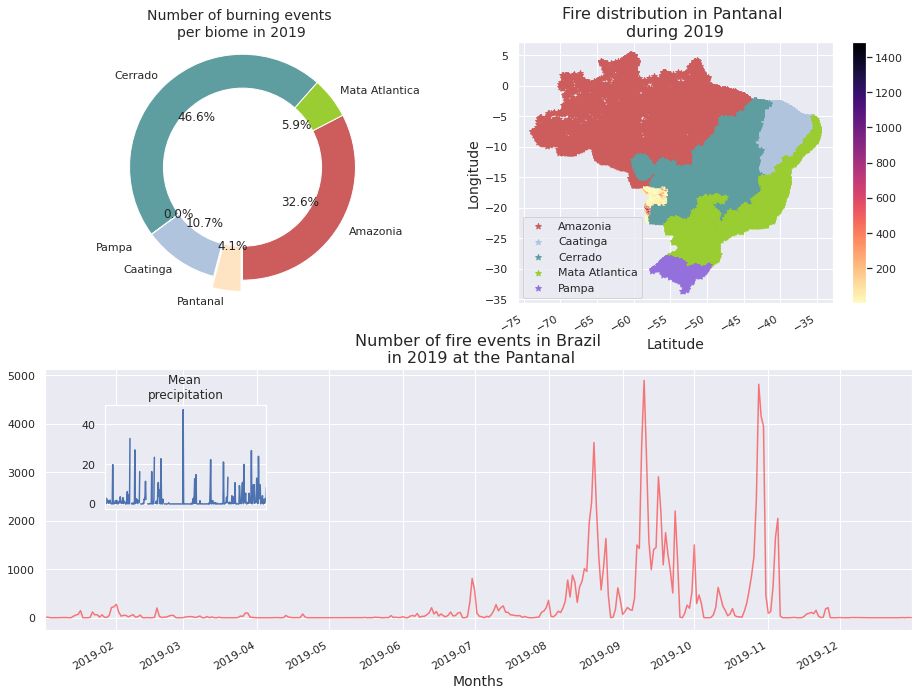

In [169]:
## Creating the composed plot

fig = plt.figure(constrained_layout=False, figsize = (28, 12))
gs = fig.add_gridspec(nrows=6, ncols=2, left=0.05, right=0.48, wspace=0.2, hspace = 1.5)
ax1 = fig.add_subplot(gs[:3, :1])
ax2 = fig.add_subplot(gs[:3, 1:])
ax3 = fig.add_subplot(gs[3:, :])

biome = 'Pantanal'
year = 2019

pie_chart_year(year, biome, ax = ax1)
plot_biome_fire = plot_biome_map(year, biome, ax2)[1]
fig.colorbar(plot_biome_fire, ax = ax2)
timeseries_year_biome(year, biome, ax = ax3, position = [0.08, 0.34, .08, .12])

plt.show()

Another interesting and pertinent plot could be Amazonia, since it was a hot topic last year and even in 2020,
where the next president, Joe Biden, mentioned that could cut some commercial relationships with Brazil if we do not take severe measures against the blazing accidents.

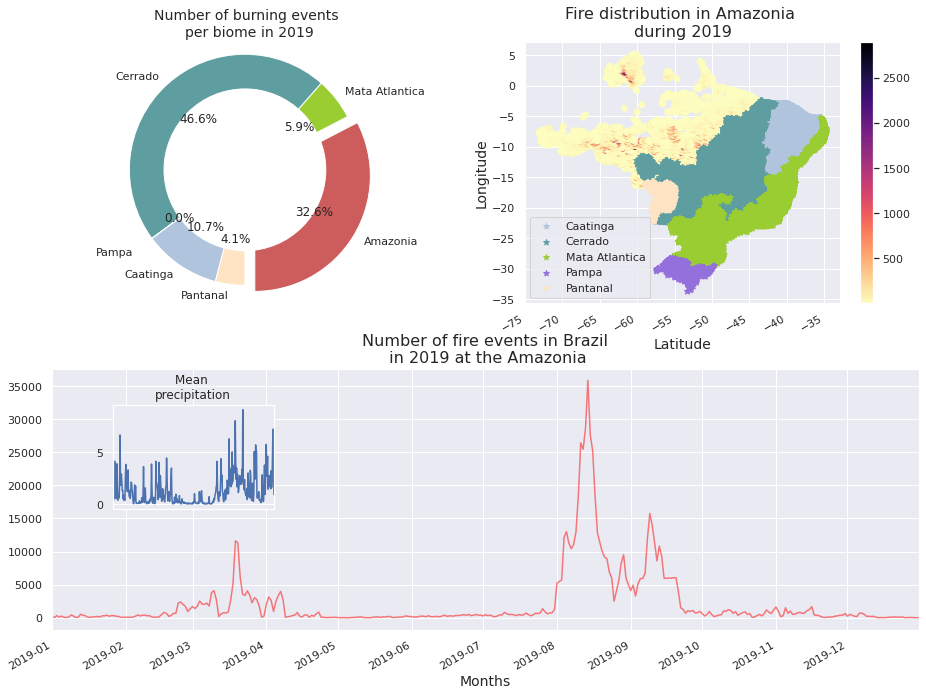

In [170]:
fig = plt.figure(constrained_layout=False, figsize = (28, 12))
gs = fig.add_gridspec(nrows=6, ncols=2, left=0.05, right=0.48, wspace=0.2, hspace = 1.5)
ax1 = fig.add_subplot(gs[:3, :1])
ax2 = fig.add_subplot(gs[:3, 1:])
ax3 = fig.add_subplot(gs[3:, :])

biome = 'Amazonia'
year = 2019

pie_chart_year(year, biome, ax = ax1)
plot_biome_fire = plot_biome_map(year, biome, ax2)[1]
fig.colorbar(plot_biome_fire, ax = ax2)
timeseries_year_biome(year, biome, ax = ax3, position = [0.08, 0.34, .08, .12])

plt.show()

* After all the work on the the first notebook, I need to update the several years analysis plot. But for the web application, I focus on the single yuar analysis: February 19th.
* **TO DO:** Create the class for these functions

# Several years analysis


At this part the user has the chance to choose among several years and make an analysis for
an specific biome for the chosen years. Since Pantanal was highly discussed last year (and Amazonia
this year, which might have serious impact even in the economy), let's take the chance to take a look on them

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Pantanal', ax1, ax2, fig)

plt.show()

<a id='several_year_analysis'></a>

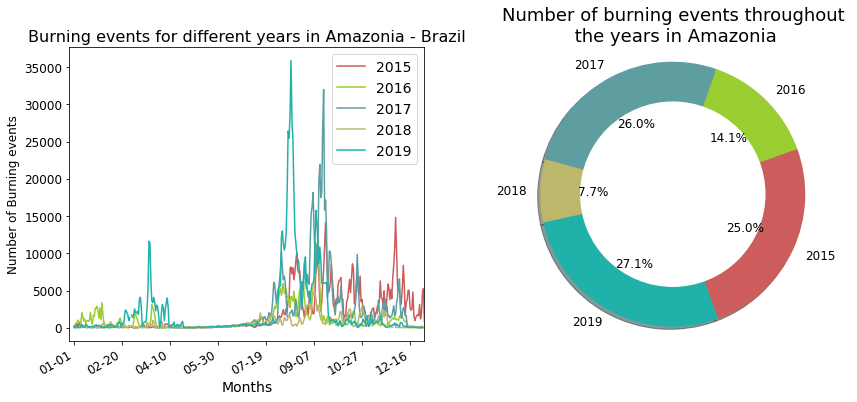

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Amazonia', ax1, ax2, fig)

plt.show()

## Side note:

This notebook still has to improved in some minor aspects, like the dates in the *x-axis*,
regarding the several years analysis and the color chosen (and perhaps some extra ones).
There are still the prediction for future years to be done. However it gives a glimpse
on what the *burning events in Brazil* - app will be showing to the user.

The EDA and the data treatment can be found [here](https://github.com/ViniciusHenning/projects/blob/master/burned-brazil/burned-brazil.ipynb). There some conclusions/correlation among several years and biomes are made, however, most of the graphs are not in the final form yet.

An investigation regarding the spreading blazes across different biomes are made
and we put it here for sake of convenience.

## Discussion about the obtained results

> **Amazonia:** We observe that in Amazonia a slightly higher number of burning
events occurred in *2019* when compared to 2017. However, in *2019* we observe
a more pronounced peak within the period end-February and begin-April
(which didn't occur before). Also, we observe that the big peaks of burning events
(which start occurring two months after the starting of the dry season) started earlier
in that year. Perhaphs it is worth investing why (by analyzing the precipitation rate).

> **Cerrado:** We observe that it follows a similar trend that Amazonia does.
*2019* a higher number of burning events occurred ($\approx 6\%$) when compared to *2017*.
However the time-pattern throughout the years stayed the same.

> **Mata Atlantica:** We again observe a similar trend (there was no shift in the
burning season) however, the number of burning events started getting much higher.
We observe a number almost $70\%$ higher than in *2017*.

> **Caatinga:** In Caatinga we also observe a huge increament of burning events in *2019*.
Since Caatinga is a small biome (covered-area-wise) in between Mata Atlantica and
Cerrado, it might be worth plotting the burning events using latitude and longitude,
to check if it is happening  therein the proximity of Mata Atlantica (which also had
a huge increment in *2019*).

> **Pampa:** it is by far the biome less afected by the blaze catastrophe.

## Mata Atlantica

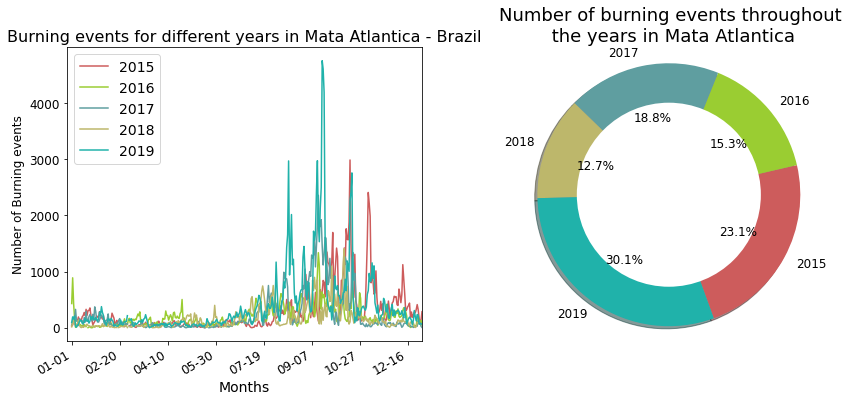

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Mata Atlantica', ax1, ax2, fig)

plt.show()

## Caatinga

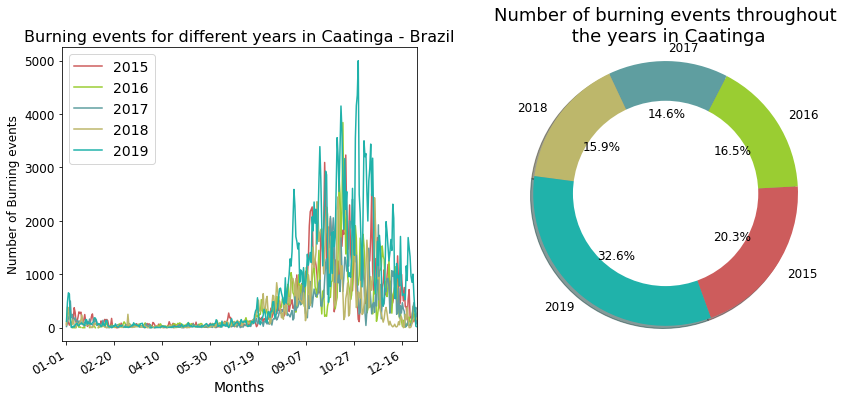

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Caatinga', ax1, ax2, fig)

plt.show()

## The investigation itself

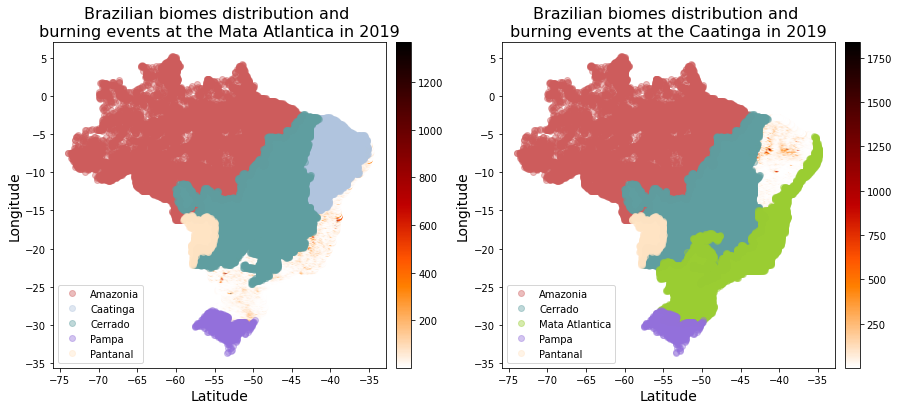

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

specific_biome_year(ax1, 2019, 'Mata Atlantica', fig, cbar_location = [0.465, 0.125, 0.015, 0.755])
specific_biome_year(ax2, 2019, 'Caatinga', fig, cbar_location = [0.91, 0.125, 0.015, 0.755])

plt.show()

We observe that the majority of blazes appeared closed to Cerrado rather than
Caatinga. It is worthwhile pointing out that there is indeed a set of burning
events happend in the very North of the Mata Atlantica biome, which is equivalent
to those nearby Cerrado. However, for the same latitude, the corresponding events
in Caatinga are pretty far apart and they are very unlikely correlated.

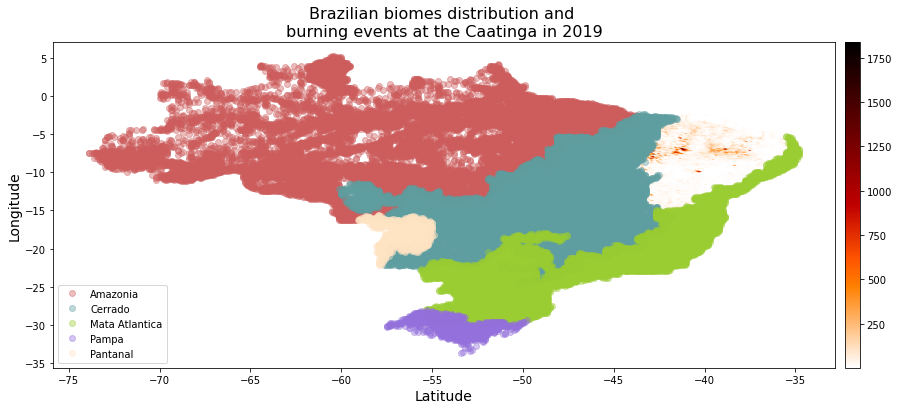

In [4]:
fig, ax = plt.subplots(figsize = (14,6))

specific_biome_year(ax, 2019, 'Caatinga', fig, cbar_location = [0.91, 0.125, 0.015, 0.755])

plt.show()

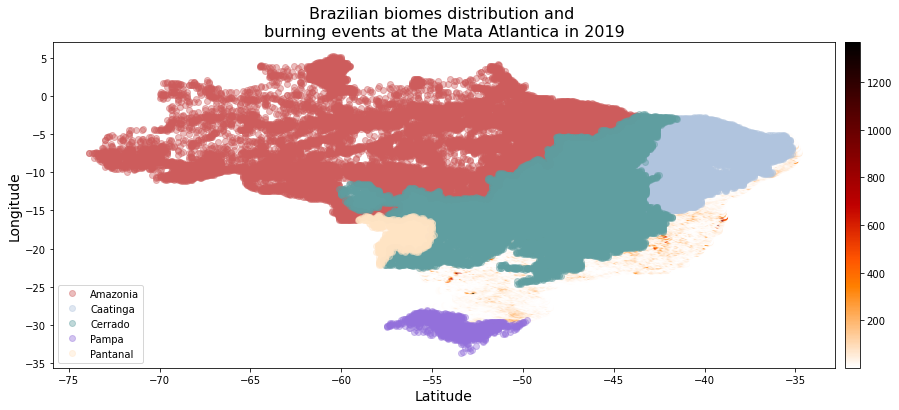

In [5]:
fig, ax = plt.subplots(figsize = (14,6))

specific_biome_year(ax, 2019, 'Mata Atlantica', fig, cbar_location = [0.91, 0.125, 0.015, 0.755])

plt.show()